# Traditional Machine Learning on hemorrhage classification

Compare the classification performance of Logisitic Regression, LDA, QDA, Random Forest Classifier, and SVM.

It's imbalanced image dataset, we use **downsampling** skill here.



In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib

In [2]:
# Read hemorrhage label file
labels = pd.read_csv("~/Downloads/BrainCTScan/new_hemorrhage_label.csv")
display(labels.head())

# # set target y
# y = labels.drop(columns=['Image'])
# y.head()

,Image,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,normal
0,ID_48c9c3858.jpg,0,1,0,0,0,0
1,ID_79d8e9cd1.jpg,0,0,0,1,0,0
2,ID_6b2f0cf23.jpg,0,0,0,1,0,0
3,ID_2bcec32fd.jpg,0,1,0,0,0,0
4,ID_13a645629.jpg,0,1,0,0,0,0


In [3]:
# Convert from one-hot encoding format to label encoding

hemorrhage_types = labels.drop(columns=['Image'])
hemorrhage_types = pd.get_dummies(hemorrhage_types).idxmax(1)
hemorrhage_types.head(10)

0    intraparenchymal
1        subarachnoid
2        subarachnoid
3    intraparenchymal
4    intraparenchymal
5              normal
6    intraventricular
7        subarachnoid
8    intraparenchymal
9    intraventricular
dtype: object

In [4]:
from sklearn.preprocessing import LabelEncoder

# Assuming y is your one-hot encoded target variable (DataFrame)
label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(hemorrhage_types)
y_encoded

array([1, 4, 4, ..., 1, 4, 1])

In [5]:
# Get the unique classes and their corresponding numerical labels
class_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# Display the class mapping
print("Class Mapping:")
for class_name, label in class_mapping.items():
    print(f"{class_name}: {label}")



Class Mapping:
epidural: 0
intraparenchymal: 1
intraventricular: 2
normal: 3
subarachnoid: 4
subdural: 5


In [6]:
labels['y_encoded'] = y_encoded
labels.head()

,Image,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,normal,y_encoded
0,ID_48c9c3858.jpg,0,1,0,0,0,0,1
1,ID_79d8e9cd1.jpg,0,0,0,1,0,0,4
2,ID_6b2f0cf23.jpg,0,0,0,1,0,0,4
3,ID_2bcec32fd.jpg,0,1,0,0,0,0,1
4,ID_13a645629.jpg,0,1,0,0,0,0,1


In [7]:
label_counts = labels['y_encoded'].value_counts()
print(label_counts)


y_encoded
1    953
2    534
3    500
4    498
5    490
0    471
Name: count, dtype: int64


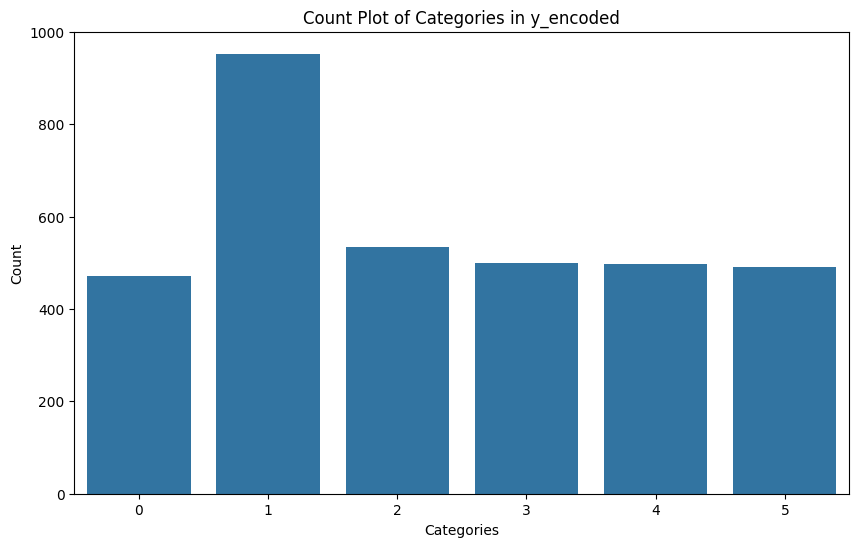

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming label_counts is the result of labels['y_encoded'].value_counts()
label_counts = labels['y_encoded'].value_counts()

# Create a count plot
plt.figure(figsize=(10, 6))
sns.countplot(x='y_encoded', data=labels)

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Count Plot of Categories in y_encoded')

# Show the plot
plt.show()


In [10]:
import os
import pandas as pd
import numpy as np
from skimage.io import imread
from skimage.transform import resize

file_dir = "~/Downloads/BrainCTScan/shuffled_images/"

data = []

for file_name in labels.Image:
    img_array = imread(os.path.join(file_dir, file_name))
    img_resized = resize(img_array, (128, 128))
    flattened_img = img_resized.flatten()
    data.append(flattened_img)

# Normalize all pixels!
data = np.array(data)/255.0
df = pd.DataFrame(data)

# Add a column for the target labels
df['Target'] = y_encoded

# Display the DataFrame shape
df.shape


(3446, 16385)

In [11]:
from imblearn.under_sampling import RandomUnderSampler

# Assuming df is your DataFrame
X = df.drop('Target', axis=1)  # Features
y = df['Target']  # Target variable

# Instantiate the RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Fit and transform the data
X_resampled, y_resampled = rus.fit_resample(X, y)

# Create a new DataFrame with the down-sampled data
df_downsampled = pd.DataFrame(X_resampled, columns=X.columns)
df_downsampled['Target'] = y_resampled

# Display the counts of each class in the down-sampled DataFrame
print("Down-sampled Class Counts:")
print(df_downsampled['Target'].value_counts())


Down-sampled Class Counts:
Target
0    471
1    471
2    471
3    471
4    471
5    471
Name: count, dtype: int64


/var/folders/l8/b2285nqj68x2y4sdjnfwd4v80000gn/T/ipykernel_9914/483381756.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_downsampled['Target'] = y_resampled


In [12]:
df_downsampled.shape

(2826, 16385)

In [13]:
from sklearn.model_selection import train_test_split

x=df_downsampled.iloc[:,:-1]
y=df_downsampled.iloc[:,-1]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state= 0)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(2260, 16384) (566, 16384)
(2260,) (566,)


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [16]:
# Train and evaluate Logistic Regression
logistic_reg = LogisticRegression()
logistic_reg.fit(x_train, y_train)  # Flatten yds_train if needed
logistic_pred = logistic_reg.predict(x_test)

# Evaluate performance
logistic_accuracy = accuracy_score(y_test, logistic_pred)
logistic_report = classification_report(y_test, logistic_pred)
conf_matrix_logistic = confusion_matrix(y_test, logistic_pred)

# Print metrics
print("Logistic Regression Accuracy:", logistic_accuracy)
print("Classification Report:\n", logistic_report)
print("Confusion Matrix:\n", conf_matrix_logistic)



Logistic Regression Accuracy: 0.2332155477031802
Classification Report:
               precision    recall  f1-score   support

           0       0.22      0.23      0.22        93
           1       0.00      0.00      0.00       113
           2       0.24      0.39      0.30        89
           3       0.27      0.55      0.36        88
           4       0.29      0.05      0.09        97
           5       0.17      0.27      0.21        86

    accuracy                           0.23       566
   macro avg       0.20      0.25      0.20       566
weighted avg       0.19      0.23      0.19       566

Confusion Matrix:
 [[21  0 18 22  5 27]
 [22  0 34 21  4 32]
 [13  0 35 18  1 22]
 [13  1 14 48  2 10]
 [12  0 24 38  5 18]
 [16  0 18 29  0 23]]


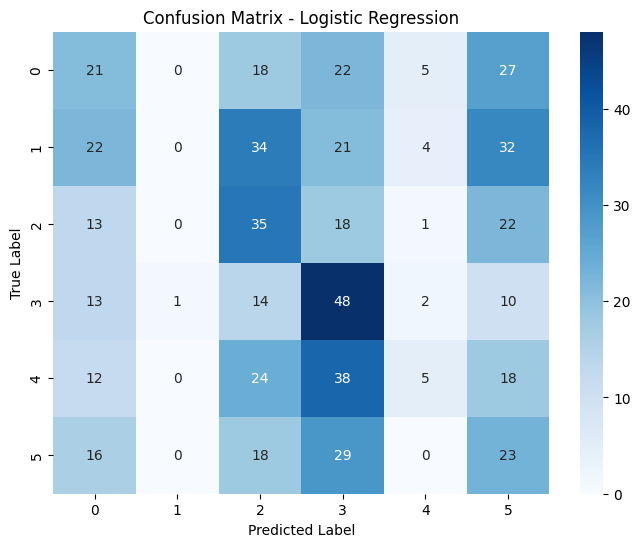

In [17]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_logistic, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


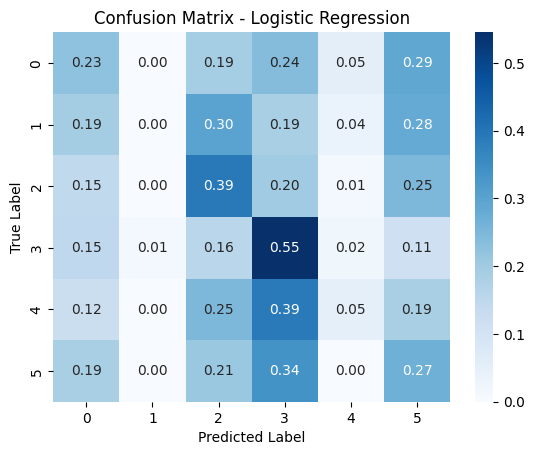

In [18]:
# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix_logistic.astype('float') / conf_matrix_logistic.sum(axis=1)[:, np.newaxis]

# Create a heatmap for visualization
sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

### LDA

In [19]:
# Train and evaluate LDA
lda = LinearDiscriminantAnalysis()
lda.fit(x_train, y_train)
lda_pred = lda.predict(x_test)

# Evaluate performance
lda_accuracy = accuracy_score(y_test, lda_pred)
lda_report = classification_report(y_test, lda_pred)
conf_matrix_lda = confusion_matrix(y_test, lda_pred)

# Print metrics
print("LDA Accuracy:", lda_accuracy)
print("LDA Report:\n", lda_report)
print("Confusion Matrix:\n", conf_matrix_lda)

LDA Accuracy: 0.3127208480565371
LDA Report:
               precision    recall  f1-score   support

           0       0.34      0.39      0.36        93
           1       0.29      0.25      0.27       113
           2       0.39      0.29      0.33        89
           3       0.34      0.35      0.35        88
           4       0.26      0.27      0.26        97
           5       0.29      0.35      0.31        86

    accuracy                           0.31       566
   macro avg       0.32      0.32      0.31       566
weighted avg       0.32      0.31      0.31       566

Confusion Matrix:
 [[36 17  4  7 14 15]
 [20 28 11 14 24 16]
 [19 17 26  9 12  6]
 [ 6 16  8 31 15 12]
 [10  9 10 16 26 26]
 [14 11  8 13 10 30]]


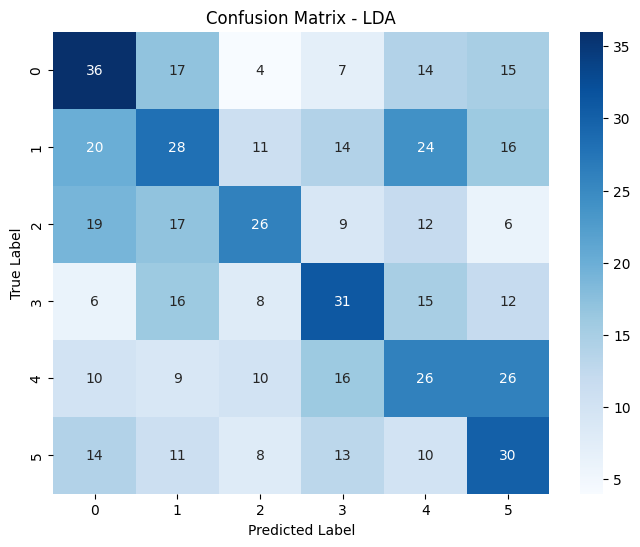

In [20]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lda, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - LDA")
plt.show()

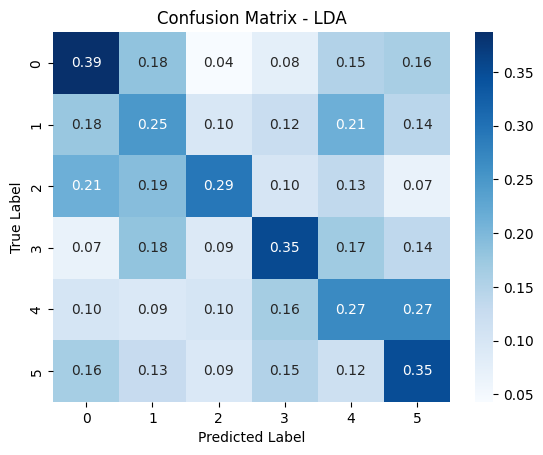

In [21]:
# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix_lda.astype('float') / conf_matrix_lda.sum(axis=1)[:, np.newaxis]

# Create a heatmap for visualization
sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - LDA")
plt.show()

### QDA

In [22]:
# Train and evaluate QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(x_train, y_train)
qda_pred = qda.predict(x_test)

# Evaluate performance
qda_accuracy = accuracy_score(y_test, qda_pred)
qda_report = classification_report(y_test, qda_pred)
conf_matrix_qda = confusion_matrix(y_test, qda_pred)

# Print metrics
print("QDA Accuracy:", qda_accuracy)
print("QDA Report:\n", qda_report)
print("Confusion Matrix:\n", conf_matrix_qda)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QDA Accuracy: 0.18904593639575973
QDA Report:
               precision    recall  f1-score   support

           0       1.00      0.01      0.02        93
           1       0.17      0.16      0.16       113
           2       0.15      0.21      0.18        89
           3       0.20      0.27      0.23        88
           4       0.22      0.23      0.22        97
           5       0.20      0.27      0.23        86

    accuracy                           0.19       566
   macro avg       0.32      0.19      0.17       566
weighted avg       0.32      0.19      0.17       566

Confusion Matrix:
 [[ 1 25 18 21 13 15]
 [ 0 18 25 20 16 34]
 [ 0 15 19 24 19 12]
 [ 0 16 22 24 15 11]
 [ 0 18 23 16 22 18]
 [ 0 15 16 16 16 23]]


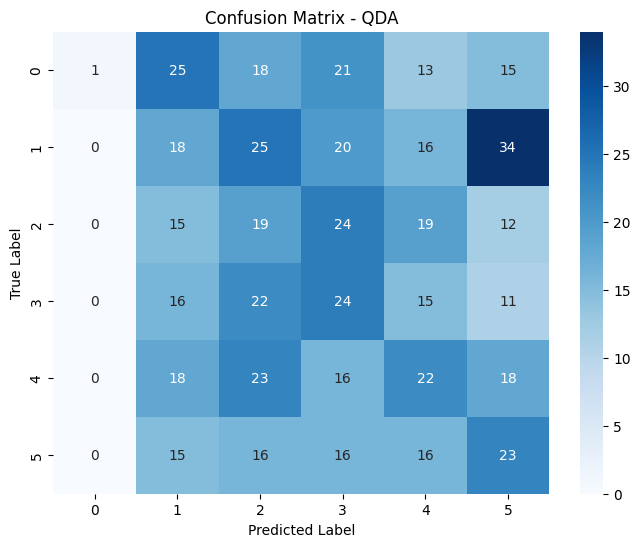

In [23]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_qda, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - QDA")
plt.show()

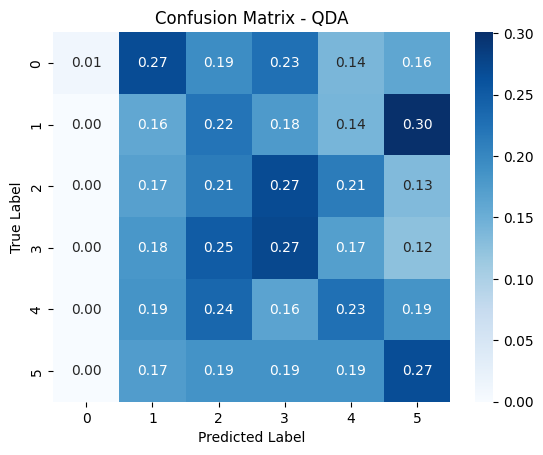

In [24]:
# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix_qda.astype('float') / conf_matrix_qda.sum(axis=1)[:, np.newaxis]

# Create a heatmap for visualization
sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - QDA")
plt.show()

### Random Forest Classification

In [25]:
from sklearn.ensemble import RandomForestClassifier

# Create Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=50, random_state=42)
rf_classifier.fit(x_train, y_train)

# Predict probabilities for each class
rf_pred = rf_classifier.predict(x_test)

# Evaluate performance
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_report = classification_report(y_test, rf_pred)
conf_matrix_rf = confusion_matrix(y_test, rf_pred)

# Print or use the evaluation metrics
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Report:\n", rf_report)
print("Confusion Matrix:\n", conf_matrix_rf)


Random Forest Accuracy: 0.3286219081272085
Random Forest Report:
               precision    recall  f1-score   support

           0       0.37      0.43      0.40        93
           1       0.33      0.19      0.25       113
           2       0.37      0.47      0.41        89
           3       0.43      0.43      0.43        88
           4       0.23      0.15      0.18        97
           5       0.24      0.34      0.28        86

    accuracy                           0.33       566
   macro avg       0.33      0.34      0.32       566
weighted avg       0.33      0.33      0.32       566

Confusion Matrix:
 [[40  5  4 13 10 21]
 [14 22 31  6 13 27]
 [14 15 42  7  5  6]
 [12  5 11 38 12 10]
 [13  8 18 15 15 28]
 [16 11  9 10 11 29]]


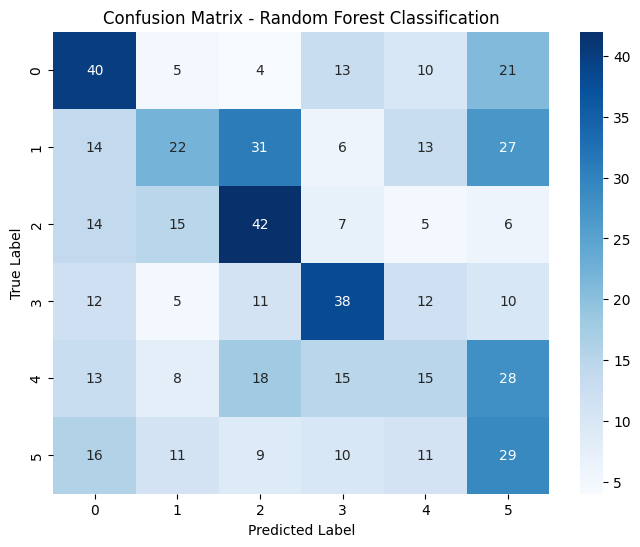

In [26]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest Classification")
plt.show()

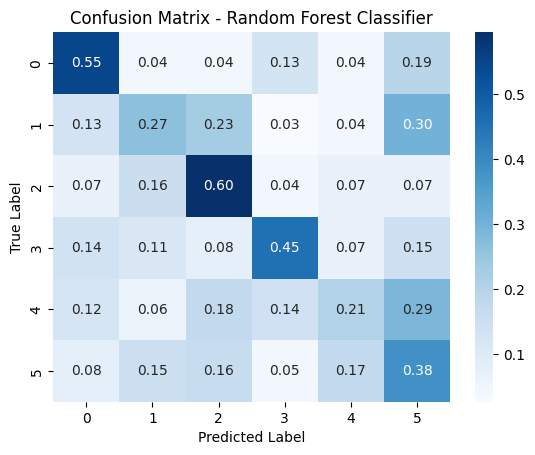

In [29]:
# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix_rf.astype('float') / conf_matrix_rf.sum(axis=1)[:, np.newaxis]

# Create a heatmap for visualization
sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest Classifier")
plt.show()

### SVM (Support Vector Machine)

In [27]:
#Can also use SVM but RF is faster and may be more accurate.
from sklearn import svm
SVM_model = svm.SVC(decision_function_shape='ovo')  #For multiclass classification
SVM_model.fit(x_train, y_train)

# Predict probabilities for each class
SVM_pred = SVM_model.predict(x_test)

# Evaluate performance
SVM_accuracy = accuracy_score(y_test, SVM_pred)
SVM_report = classification_report(y_test, SVM_pred)
conf_matrix_SVM = confusion_matrix(y_test, SVM_pred)

# Print or use the evaluation metrics
print("SVM Accuracy:", SVM_accuracy)
print("SVM Report:\n", SVM_report)
print("Confusion Matrix:\n", conf_matrix_SVM)

SVM Accuracy: 0.284452296819788
SVM Report:
               precision    recall  f1-score   support

           0       0.29      0.44      0.35        93
           1       0.26      0.16      0.20       113
           2       0.31      0.38      0.34        89
           3       0.42      0.40      0.41        88
           4       0.17      0.09      0.12        97
           5       0.22      0.28      0.24        86

    accuracy                           0.28       566
   macro avg       0.28      0.29      0.28       566
weighted avg       0.28      0.28      0.27       566

Confusion Matrix:
 [[41  6  8 11  7 20]
 [26 18 24  6 15 24]
 [22 18 34  2  3 10]
 [14  7 11 35  8 13]
 [18 11 19 21  9 19]
 [18 10 13  9 12 24]]


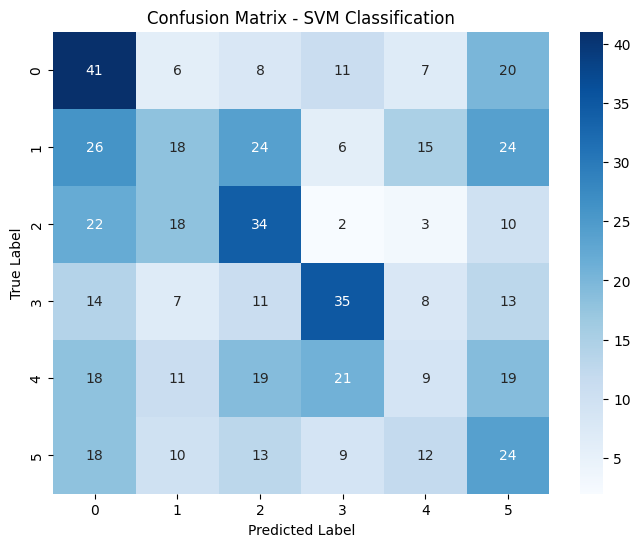

In [28]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_SVM, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - SVM Classification")
plt.show()

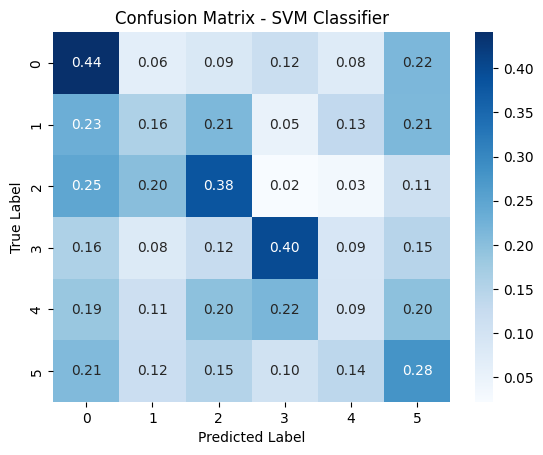

In [29]:
# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix_SVM.astype('float') / conf_matrix_SVM.sum(axis=1)[:, np.newaxis]

# Create a heatmap for visualization
sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - SVM Classifier")
plt.show()